In [1]:
import os
import random
import time
import cv2
import numpy as np
from scipy import ndimage
import torch
import torch.nn as nn
import torchvision.datasets as dataset
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image,ImageStat
from visdom import Visdom

# load MNIST dataset
root = "/home/robin/Thesis/Autoencoder/MNIST1_data"
if not(os.path.exists(root)):
    os.mkdir(root)
    


In [2]:
#overirde the MNIST base class to return the centroid and thw transformed image. Have alook 
#at the readme section for more details.

class MNIST1(dataset.MNIST):
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target,mean_pixel) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')
        
        ##afine transform acording a randome offset
        def affine_trans(img):
            image = torch.squeeze(img,0)
            rnumber = [random.uniform(0,3) for x in range(2)]
            #returns a torch tensor of rnumber..
            rnumber = torch.FloatTensor(rnumber)
            x_offset,y_offset = rnumber 
            M = np.float32([[1,0,x_offset],[0,1,y_offset]])
            rows,cols = rows,cols = image.shape[0:]
            result = cv2.warpAffine(image.numpy(),M,(rows,cols))
            result = torch.from_numpy(result).float()
            return rnumber,result
        
        
        if self.transform is not None:
            img = self.transform(img)
            new_img = torch.squeeze(img,0)
            rnumber,result = affine_trans(img)
            centroid = list(ndimage.measurements.center_of_mass(new_img.numpy()))
            centroid = torch.FloatTensor(centroid)
            
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        values = {"image":img,"target":target,
                 "centroid":centroid,"randnum":rnumber,"warp_img":result}
        #return img,target,centroid_x,centroid_y,rnumber,result
        return values
    


In [3]:
#create the dataloders..

trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = MNIST1(root=root, train=True, transform=trans, download=True)
test_set = MNIST1(root=root, train=False, transform=trans, download=True)

batch_size = 256
train_loader = DataLoader(dataset=train_set,
                 batch_size=batch_size,
                shuffle=True,pin_memory=False)
test_loader = DataLoader(dataset=test_set,
                 batch_size=batch_size,
                shuffle=True,pin_memory=False)
#create a dataloader dictionary
dataloaders = {"train":train_loader,"val":test_loader}

print(len(dataloaders["train"]))
print ('==>>> total training batch number: {}'.format(len(train_loader)))
print ('==>>> total testing batch number: {}'.format(len(test_loader)))

235
==>>> total training batch number: 235
==>>> total testing batch number: 40


In [6]:
def visualize(inputs,output,n):
    plt.figure(figsize= (18,4))
    for i in range(n):
        ax1 = plt.subplot(2,n,i+1)
        ax1.set_title("input")
        ax1.axis("off")
        plt.imshow(inputs[i][0],cmap ="gray",interpolation ='none')
        ax2 = plt.subplot(2,n ,i+1+n)
        ax2.set_title("warped image")
        ax2.axis("off")
        plt.imshow(output[i][0],cmap ="gray",interpolation ='none')
        

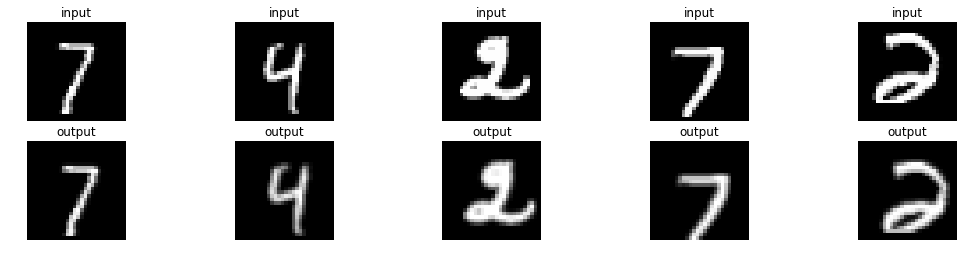

In [9]:
#it's always good to check whether your datas are loaded properly,
for index,sampled_batch in enumerate (train_loader):
    image,warp_image =sampled_batch["image"],sampled_batch["warp_img"] 
    warp_image = torch.unsqueeze(warp_image,1)
    visualize(image,warp_image,5)
    if index == 0:
        break

In [12]:
#NN model 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder =  nn.Sequential(
                        nn.Linear(28*28,256),
                        nn.ReLU(True),
                        nn.Linear(256,128),
                        nn.ReLU(True),
                        nn.Linear(128,64),nn.ReLU(True),
                        nn.Linear(64,20)
                        )
        self.decoder =  nn.Sequential(
                        nn.Linear(20,64),nn.ReLU(True),
                        nn.Linear(64,128),nn.ReLU(True),
                        nn.Linear(128,256),nn.ReLU(True),
                        nn.Linear(256,28*28),nn.Tanh()
                        )
    def forward(self,x,offset):
        encoded = self.encoder(x)
        decoded = torch.add(offset,encoded)
        decoded = self.decoder(decoded)
        return encoded,decoded


#Create the    
class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')
    


In [15]:
def visualize(inputs,output,n):
    plt.figure(figsize= (18,4))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(inputs[i][0],cmap ="gray",interpolation ='none')
        ax = plt.subplot(2,n ,i+1+n)
        plt.imshow(output[i][0],cmap ="gray",interpolation ='none')
        

originalimage centroid tensor([14.1695, 14.4318])
warp image centroid [16.21306723518759, 15.325777240927707]
centroid calculated from the reconstructed image [15.969066837993193, 15.248628592170329]
centroid values from model tensor([14.1971, 14.4692])


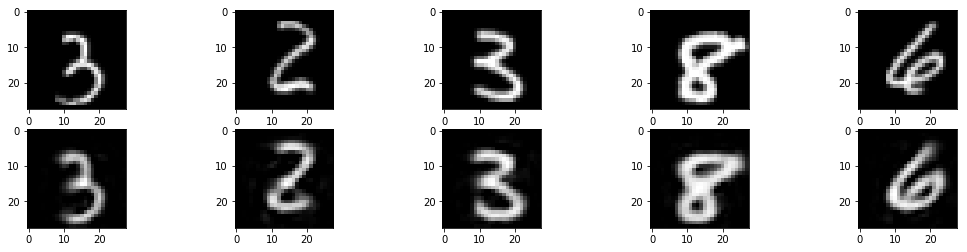

In [16]:
#Evaluation 
logs_path = '/home/robin/Thesis/Autoencoder/logs/centroid_auto2/train_centroid2_epoch389.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
checkpoint = torch.load(logs_path)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.eval()

for index,sampled_batch in enumerate (train_loader,0):
    image,warp_image =sampled_batch["image"],sampled_batch["warp_img"] 
    inputs = image.view(image.size(0),-1).to(device)     #shape [batch_size*784]
    shifted_inputs = warp_image.view(warp_image.size(0),-1).to(device)   #shape [batch_size*784]
    offset = sampled_batch["randnum"]   #shape [batch_size*2]
    #converted to the dimension of encoded o/p from model to get added.
    offset = F.pad(input=offset, pad=(18, 0, 0, 0), mode='constant', value=0)
    centroid = sampled_batch["centroid"]   #shape [batch_size*2]
    ##since centre of mass (centroid return the y centroid first, we swap the
    #columns of centroid tensor..)
    centroid = torch.index_select(centroid, 1, torch.LongTensor([1,0]))

    ##forward..
    encode_out,output = model(inputs,offset.to(device))
    
    #resize the model output to our input image dimensions(28*28*1)
    output = output.detach().cpu()
    output = output.clamp(0,1)
    output = output.view(output.size(0),1,28,28)
   
    
    warp_image = torch.unsqueeze(warp_image,1)
    #feel free to chnge the parameters passing the visualization
    visualize(warp_image,output,5)
    
    #CHECK THE CENTROID BETWEEN WARP_IMAGE AND OUTPUT
    print("originalimage centroid",centroid[0])
    centroid_output= list(ndimage.measurements.center_of_mass(output[0][0].numpy()))
    centroid_image = list(ndimage.measurements.center_of_mass(warp_image[0][0].numpy()))
    print("warp image centroid",centroid_image)
    print("centroid calculated from the reconstructed image",centroid_output)
    centroid_out = encode_out[:,18:20]
    print("centroid values from model",centroid_out[0].detach().cpu())
    if index ==0:
        break